# Поиск вставок

Будем искать вставки глядя на GC и смещение GC (GC skew). Отрезки с аномальным для данной последовательности GC skew, скорее всего, и будут местами вставок. Поиск осуществим графическим способом.

## Case 1

Для начала посмотрим на график GC skew. Это уже позволит прикинуть место вставки с хорошей точностью. Отметим, что для такого приблизительного решения стоит немного поэкспериментировать с длиной "окон", для которых вычисляется GC skew, чтобы различия были лучше видны.

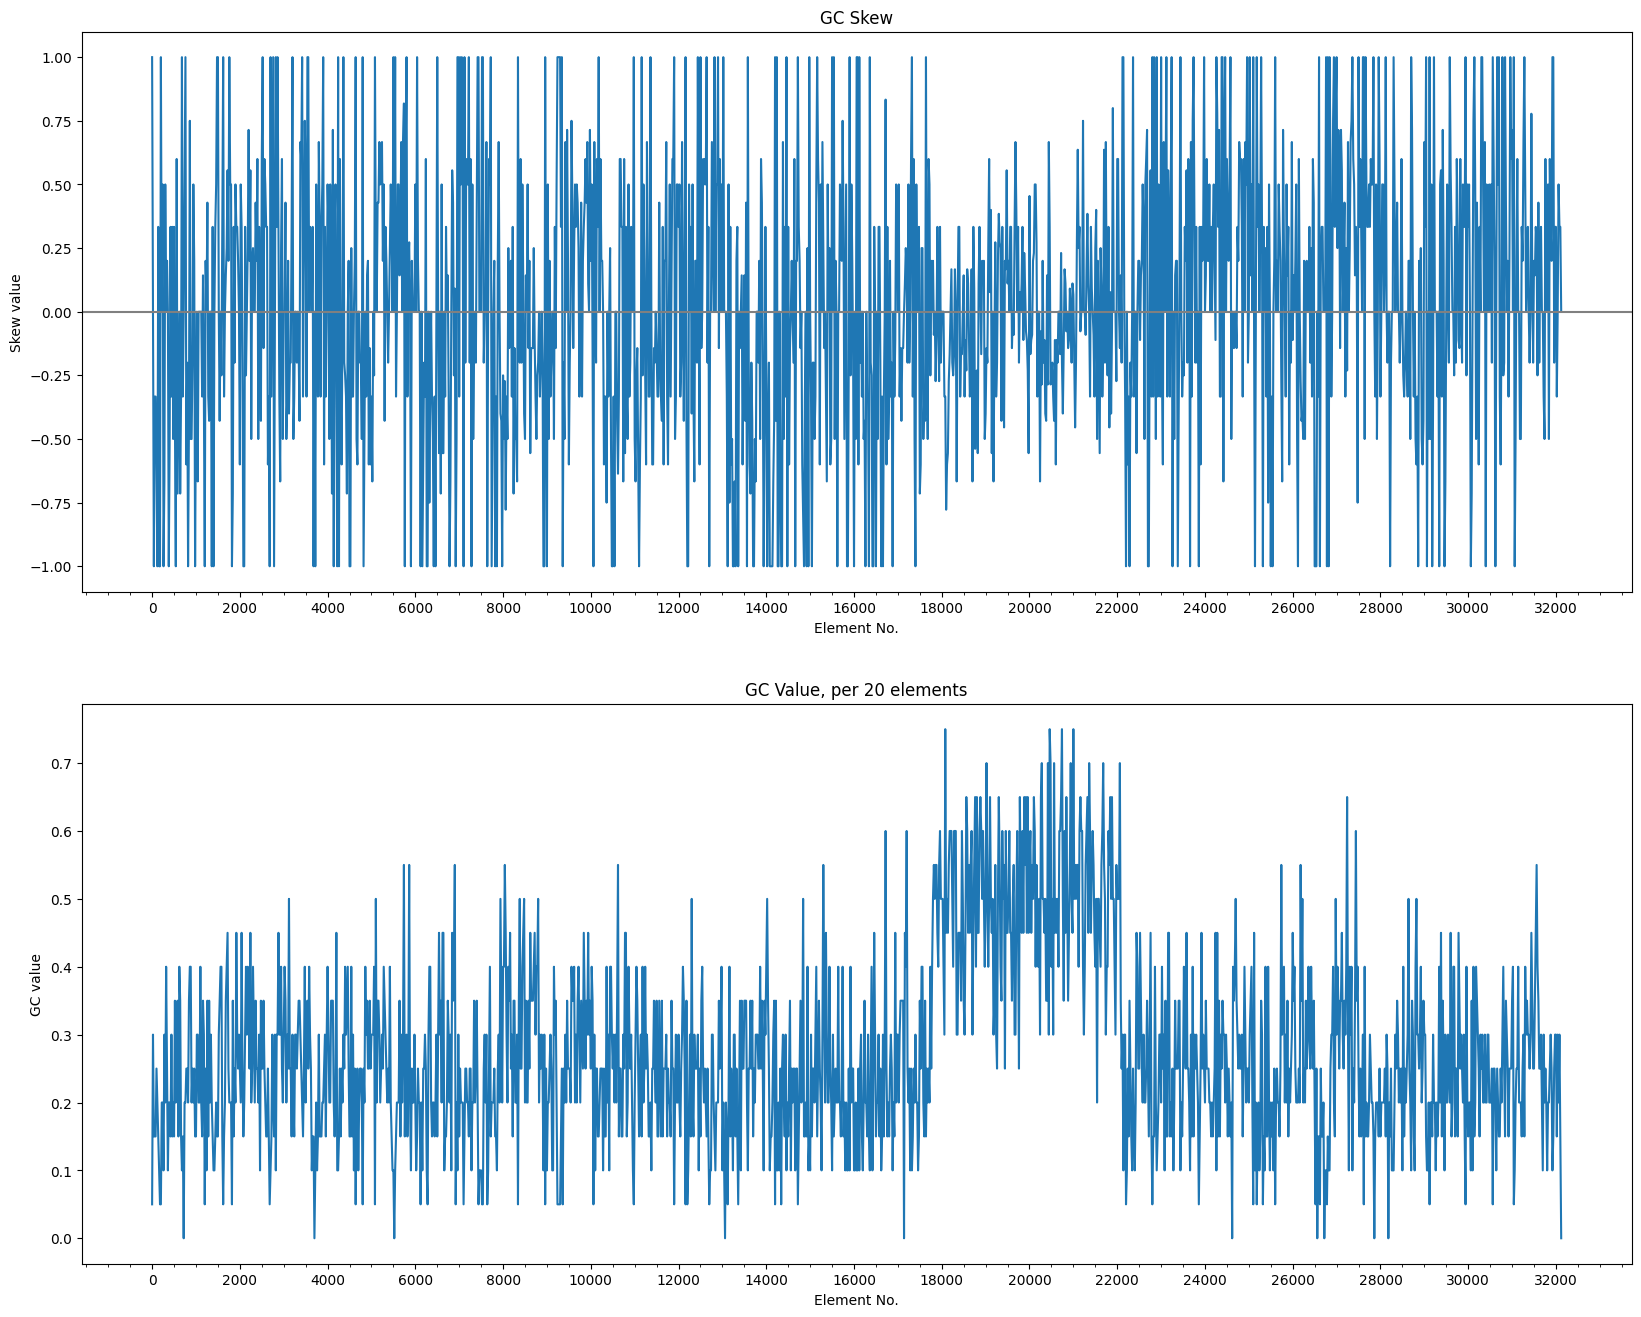

In [499]:
import Bio.SeqUtils as SU
from Bio import SeqIO

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

seq_orig = ""

with open("01.fasta") as handle:
    for record in SeqIO.parse(handle, "fasta"):
        seq_orig = record

current_sub = ""
current_max_insertion = ""

window_size = 20

skew = SU.GC_skew(seq_orig, window_size)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 16))
ax1.set_title("GC Skew")
ax1.plot(range(0, len(seq_orig), window_size), skew)
ax1.set_xlabel("Element No.")
ax1.set_ylabel("Skew value")
ax1.xaxis.set_minor_locator(MultipleLocator(500))
ax1.xaxis.set_major_locator(MultipleLocator(2000))
ax1.axhline(0, color='grey')

step = 20
gc_list = []
for i in range(0, len(seq_orig), step):
    lb = step
    if i+step >= len(seq_orig):
        lb = len(seq_orig)-i

    gc_list.append(SU.gc_fraction(seq_orig[i:i+lb]))

ax2.set_title(f'GC Value, per {step} elements')
ax2.plot(range(0, len(seq_orig), step), gc_list)
ax2.set_xlabel("Element No.")
ax2.set_ylabel("GC value")
ax2.xaxis.set_minor_locator(MultipleLocator(500))
ax2.xaxis.set_major_locator(MultipleLocator(2000))

plt.show()


Можно заметить, что примерно между 17 500 и 22 500 элементами модуль GC skew в среднем намного ниже, чем до и после этого отрезка. На нём же GC резко растёт. Попробуем рассмотреть этот отрезок поближе.

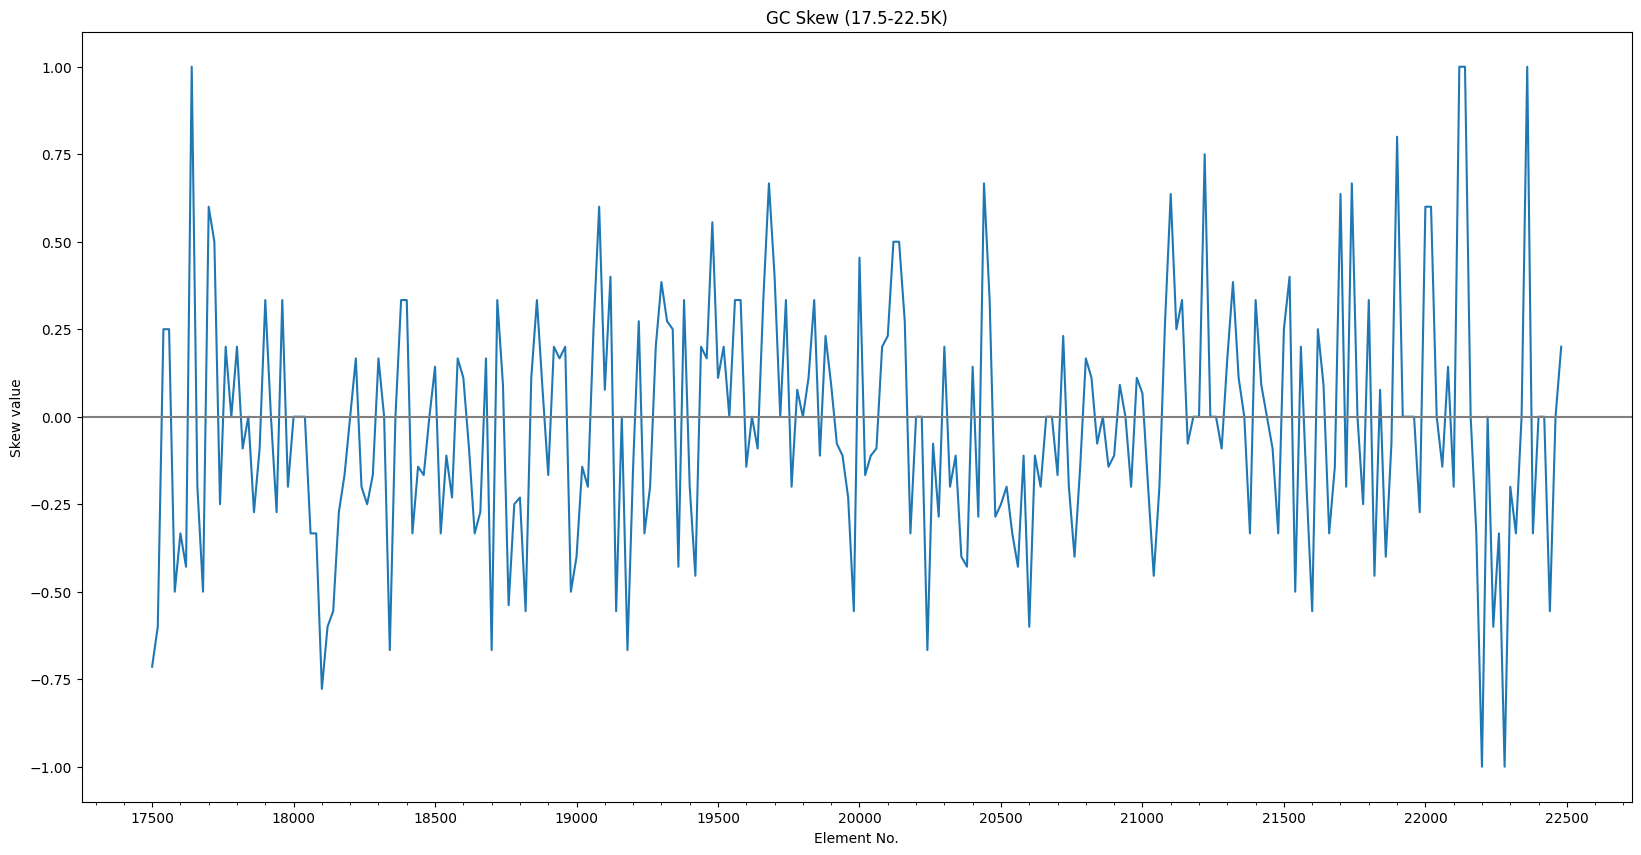

In [500]:
window_size = 20

border_left = 17500
border_right = 22500

seq_17_23 = seq_orig[border_left:border_right]

skew_17_23 = SU.GC_skew(seq_17_23, window_size)

fig_17_23, ax17_23 = plt.subplots(figsize=(20, 10))
ax17_23.set_title("GC Skew (17.5-22.5K)")
ax17_23.plot(range(border_left, border_right, window_size), skew_17_23)
ax17_23.set_xlabel("Element No.")
ax17_23.set_ylabel("Skew value")
ax17_23.xaxis.set_minor_locator(MultipleLocator(100))
ax17_23.xaxis.set_major_locator(MultipleLocator(500))
ax17_23.axhline(0, color='grey')

plt.show()


Присмотримся к правому и левому концам отрезка поближе. Можно сделать размер "окна" вычисления GC skew поменьше.

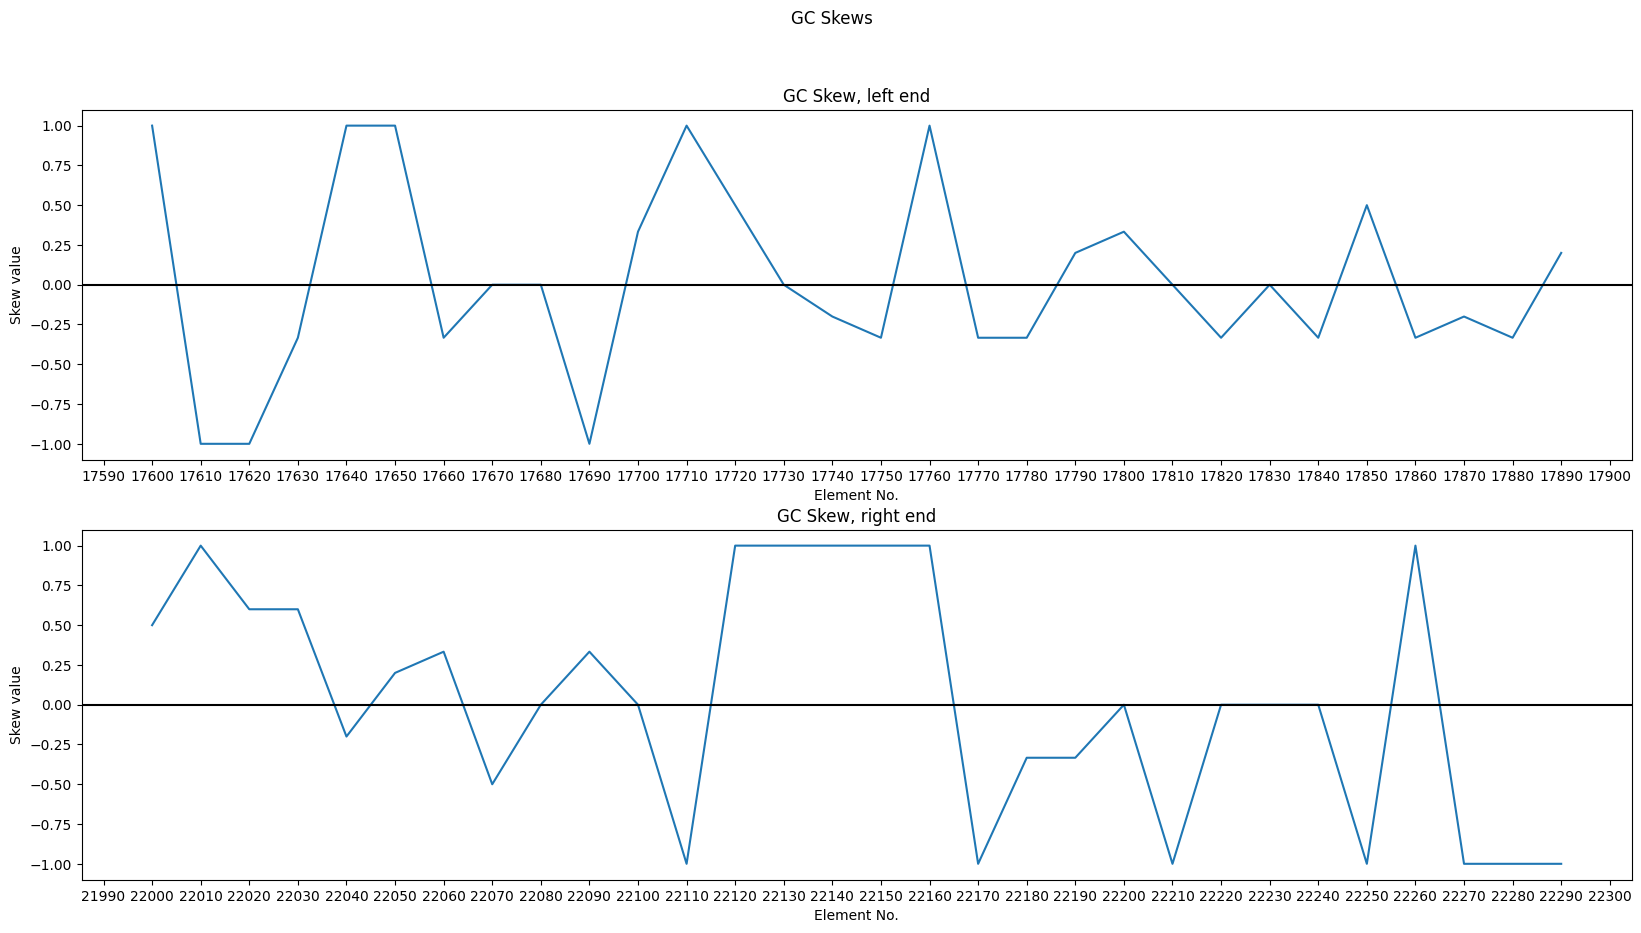

In [501]:
window_size1 = 10

fig_3, (ax_l, ax_r) = plt.subplots(2, 1, figsize=(20, 10))
fig_3.suptitle("GC Skews")

border_left_l = 17600
border_right_l = 17900

seq_l = seq_orig[border_left_l:border_right_l]
skew_l = SU.GC_skew(seq_l, window_size1)

ax_l.set_title("GC Skew, left end")
ax_l.plot(range(border_left_l, border_right_l, window_size1), skew_l)
ax_l.set_xlabel("Element No.")
ax_l.set_ylabel("Skew value")
ax_l.xaxis.set_major_locator(MultipleLocator(10))
ax_l.axhline(0, color='black')

border_left_r = 22000
border_right_r = 22300

seq_r = seq_orig[border_left_r:border_right_r]
skew_r = SU.GC_skew(seq_r, window_size1)

ax_r.set_title("GC Skew, right end")
ax_r.plot(range(border_left_r, border_right_r, window_size1), skew_r)
ax_r.set_xlabel("Element No.")
ax_r.set_ylabel("Skew value")
ax_r.xaxis.set_major_locator(MultipleLocator(10))
ax_r.axhline(0, color='black')

plt.show()


Снова уменьшим "окно" и приблизим масштаб ещё ближе?

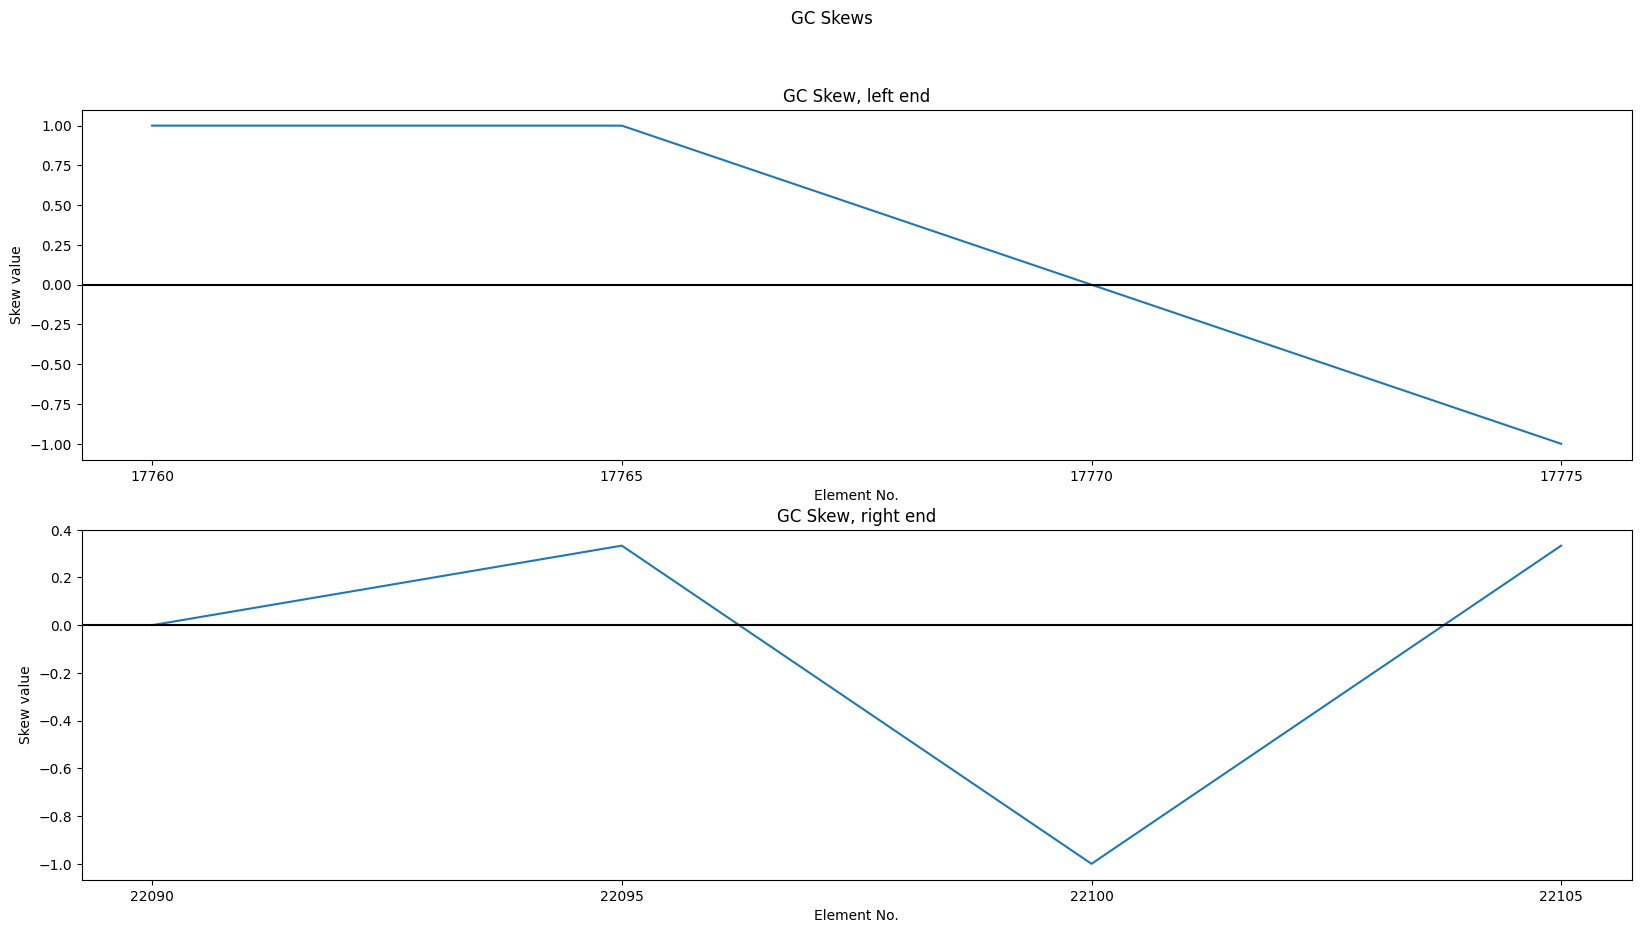

In [502]:
window_size1 = 5

fig_3, (ax_l, ax_r) = plt.subplots(2, 1, figsize=(20, 10))
fig_3.suptitle("GC Skews")

border_left_l = 17760
border_right_l = 17780

seq_l = seq_orig[border_left_l:border_right_l]
skew_l = SU.GC_skew(seq_l, window_size1)

ax_l.set_title("GC Skew, left end")
ax_l.plot(range(border_left_l, border_right_l, window_size1), skew_l)
ax_l.set_xlabel("Element No.")
ax_l.set_ylabel("Skew value")
ax_l.xaxis.set_major_locator(MultipleLocator(5))
ax_l.axhline(0, color='black')

border_left_r = 22090
border_right_r = 22110

seq_r = seq_orig[border_left_r:border_right_r]
skew_r = SU.GC_skew(seq_r, window_size1)

ax_r.set_title("GC Skew, right end")
ax_r.plot(range(border_left_r, border_right_r, window_size1), skew_r)
ax_r.set_xlabel("Element No.")
ax_r.set_ylabel("Skew value")
ax_r.xaxis.set_major_locator(MultipleLocator(5))
ax_r.axhline(0, color='black')

plt.show()


Вряд ли мы сможем получить места начала и конца вставки с большей точностью таким образом. 

#### Ответ

**Левая граница** = 17770

**Правая граница** = 22095

In [503]:
print(f'Insertion length: {current_max_insertion.__len__()}')
print(f'Borders: left - {border_left}; right - {border_right}')
print(f'Insertion GC: {SU.gc_fraction(current_max_insertion)}')

Insertion length: 0
Borders: left - 17500; right - 22500
Insertion GC: 0


## Case2

Original record length: 2393931
Original GC score: 0.551168768022136


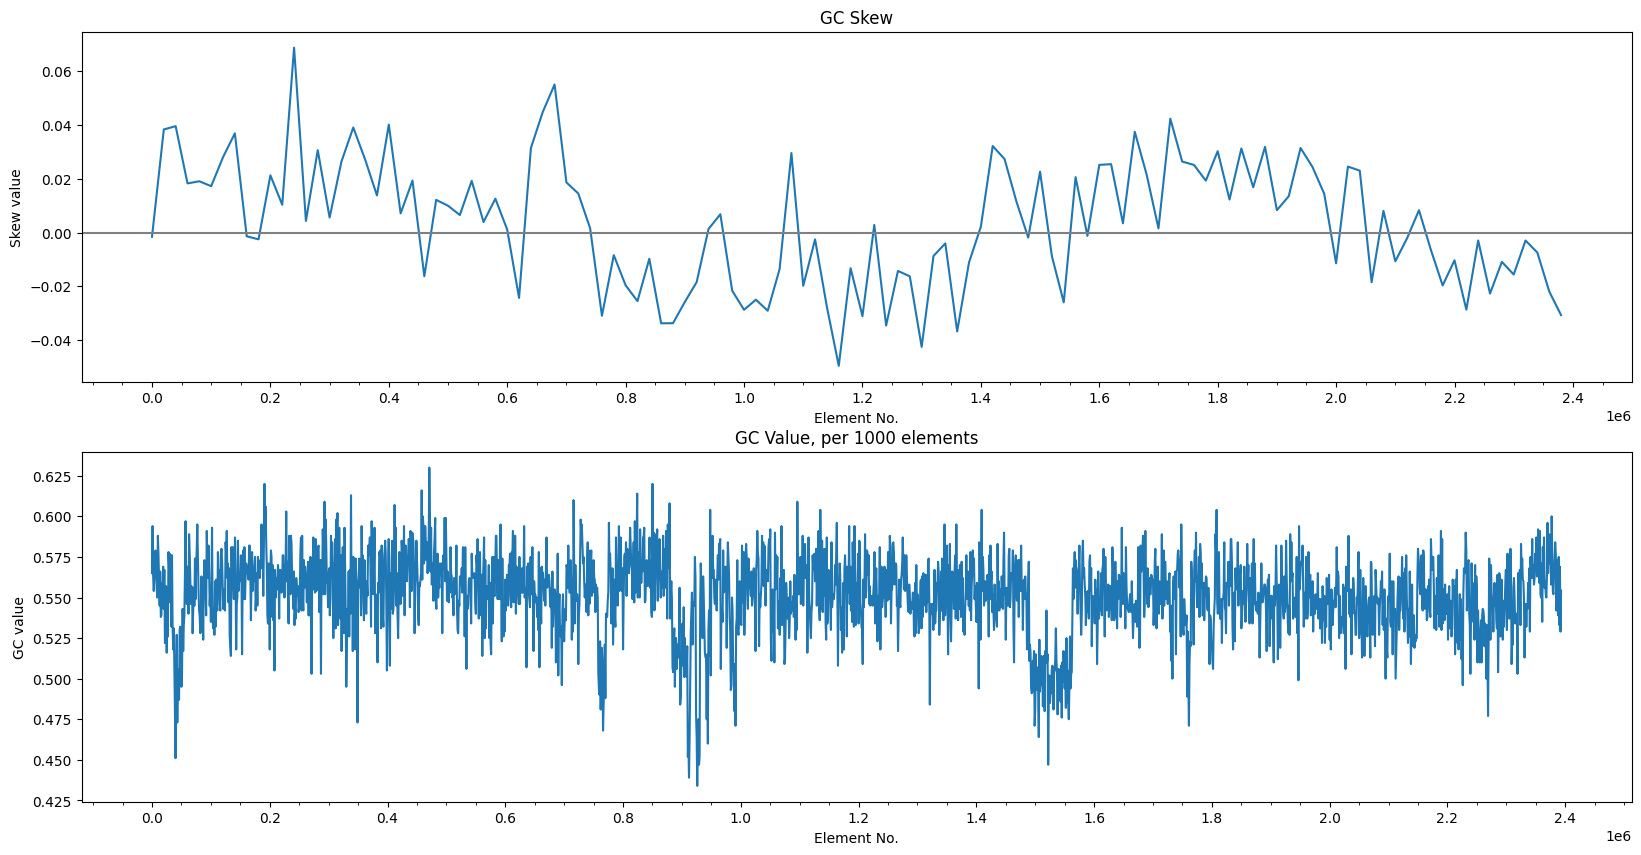

In [504]:
seq_orig = ""

with open("02.fasta") as handle:
    for record in SeqIO.parse(handle, "fasta"):
        seq_orig = record

print(f'Original record length: {seq_orig.__len__()}')
print(f'Original GC score: {SU.gc_fraction(seq_orig)}')

window_size = 20000

skew = SU.GC_skew(seq_orig, window_size)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))
ax1.set_title("GC Skew")
ax1.plot(range(0, len(seq_orig), window_size), skew)
ax1.set_xlabel("Element No.")
ax1.set_ylabel("Skew value")
ax1.xaxis.set_minor_locator(MultipleLocator(50000))
ax1.xaxis.set_major_locator(MultipleLocator(200000))
ax1.axhline(0, color='grey')

step = 1000
gc_list = []
for i in range(0, len(seq_orig), step):
    lb = step
    if i+step >= len(seq_orig):
        lb = len(seq_orig)-i

    gc_list.append(SU.gc_fraction(seq_orig[i:i+lb]))

ax2.set_title(f'GC Value, per {step} elements')
ax2.plot(range(0, len(seq_orig), step), gc_list)
ax2.set_xlabel("Element No.")
ax2.set_ylabel("GC value")
ax2.xaxis.set_minor_locator(MultipleLocator(50000))
ax2.xaxis.set_major_locator(MultipleLocator(200000))

plt.show()


Примерно в районе 1.5-1.6 млн. наблюдается обвальное уменьшение GC, а затем такое же резкое восстановление.

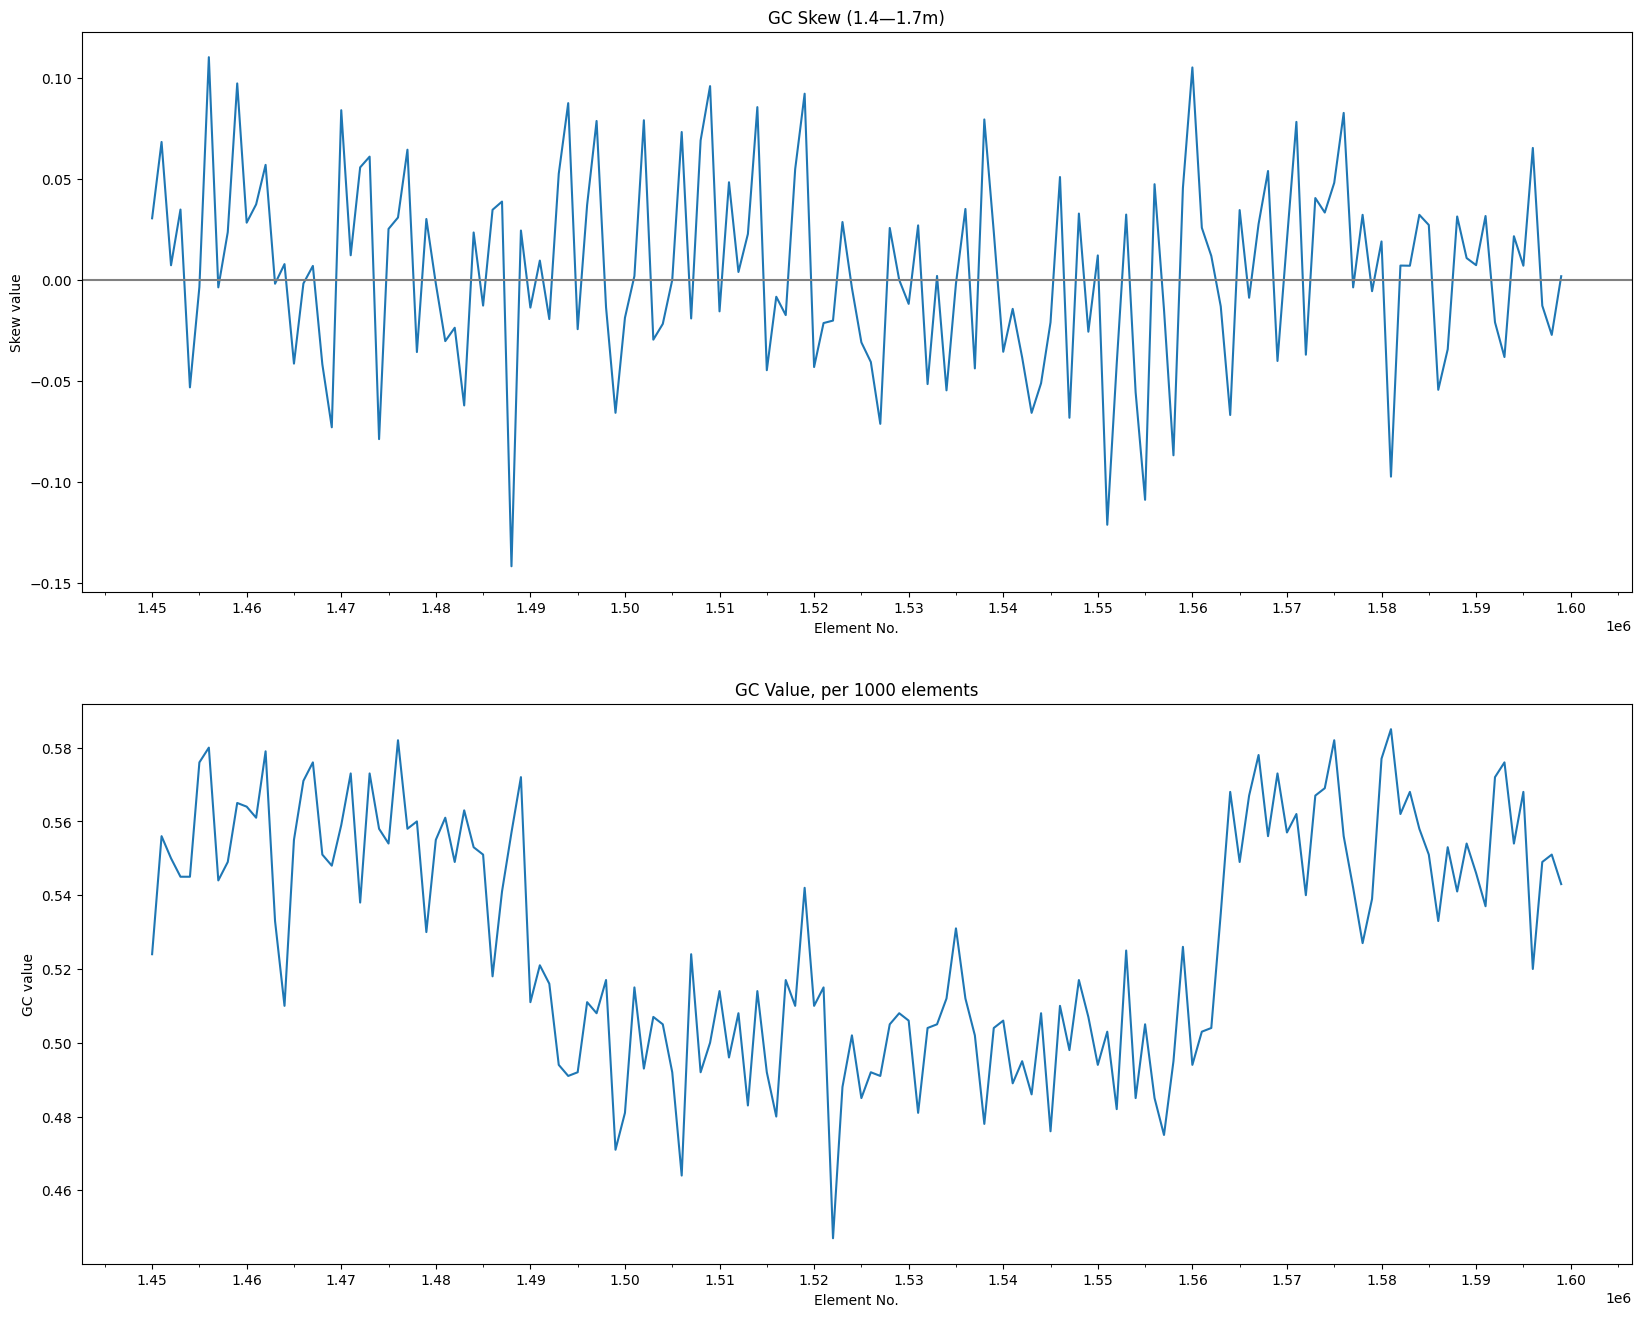

In [505]:
window_size = 1000

border_left = 1450 * 1000
border_right = 1600 * 1000

seq_14_17 = seq_orig[border_left:border_right]

skew_14_17 = SU.GC_skew(seq_14_17, window_size)

fig_17_23, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 16))
ax1.set_title("GC Skew (1.4—1.7m)")
ax1.plot(range(border_left, border_right, window_size), skew_14_17)
ax1.set_xlabel("Element No.")
ax1.set_ylabel("Skew value")
ax1.xaxis.set_minor_locator(MultipleLocator(5000))
ax1.xaxis.set_major_locator(MultipleLocator(10000))
ax1.axhline(0, color='grey')

step = 1000
gc_list = []
for i in range(0, len(seq_14_17), step):
    lb = step
    if i+step >= len(seq_14_17):
        lb = len(seq_14_17)-i

    gc_list.append(SU.gc_fraction(seq_14_17[i:i+lb]))

ax2.set_title(f'GC Value, per {step} elements')
ax2.plot(range(border_left, border_right, step), gc_list)
ax2.set_xlabel("Element No.")
ax2.set_ylabel("GC value")
ax2.xaxis.set_minor_locator(MultipleLocator(5000))
ax2.xaxis.set_major_locator(MultipleLocator(10000))

plt.show()


Между 1.49 млн. и 1.565 млн. наблюдается резкий подъём. Рассмотрим его начало и конец поближе.

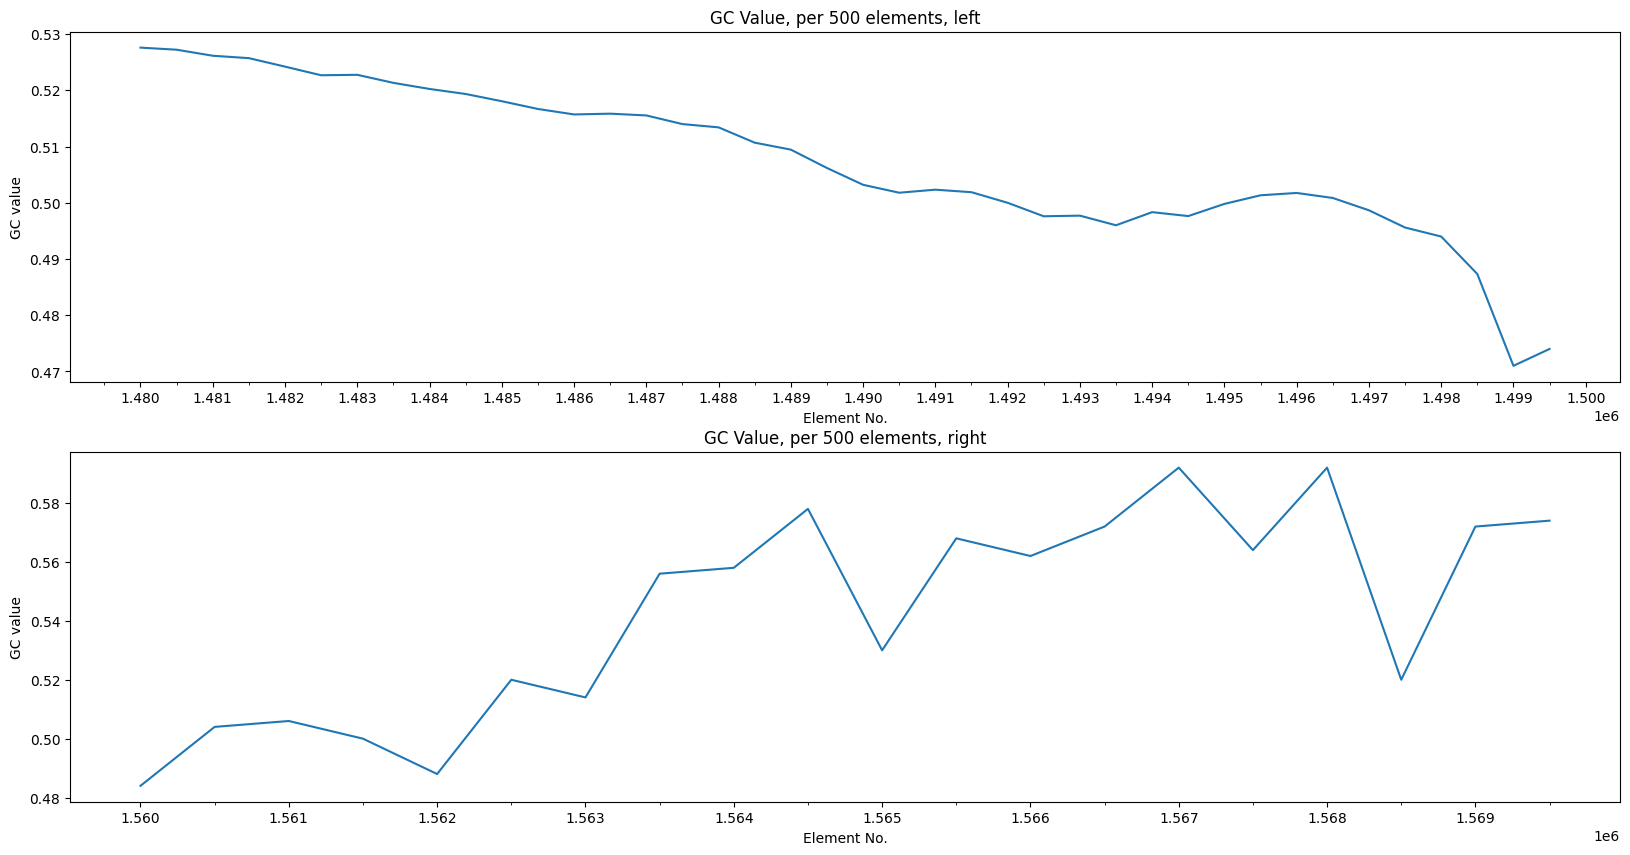

In [506]:
border_left_l = 1480*1000
border_right_l = 1500*1000
seq_l = seq_orig[border_left_l:border_right_l]
gc_list_l = []

step = 500

for i in range(0, len(seq_l), step):
    lb = step
    if i+step <= len(seq_l):
        lb = len(seq_l)-i

    gc_list_l.append(SU.gc_fraction(seq_l[i:i+lb]))

fig_17_23, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))
ax1.set_title(f"GC Value, per {step} elements, left")
ax1.plot(range(border_left_l, border_right_l, step), gc_list_l)
ax1.set_xlabel("Element No.")
ax1.set_ylabel("GC value")
ax1.xaxis.set_minor_locator(MultipleLocator(500))
ax1.xaxis.set_major_locator(MultipleLocator(1000))

gc_list_r = []
border_left_r = 1560*1000
border_right_r = 1570*1000
seq_r = seq_orig[border_left_r:border_right_r]

for i in range(0, len(seq_r), step):
    lb = step
    if i+step >= len(seq_r):
        lb = len(seq_r)-i

    gc_list_r.append(SU.gc_fraction(seq_r[i:i+lb]))

ax2.set_title(f'GC Value, per {step} elements, right')
ax2.plot(range(border_left_r, border_right_r, step), gc_list_r)
ax2.set_xlabel("Element No.")
ax2.set_ylabel("GC value")
ax2.xaxis.set_minor_locator(MultipleLocator(500))
ax2.xaxis.set_major_locator(MultipleLocator(1000))

plt.show()


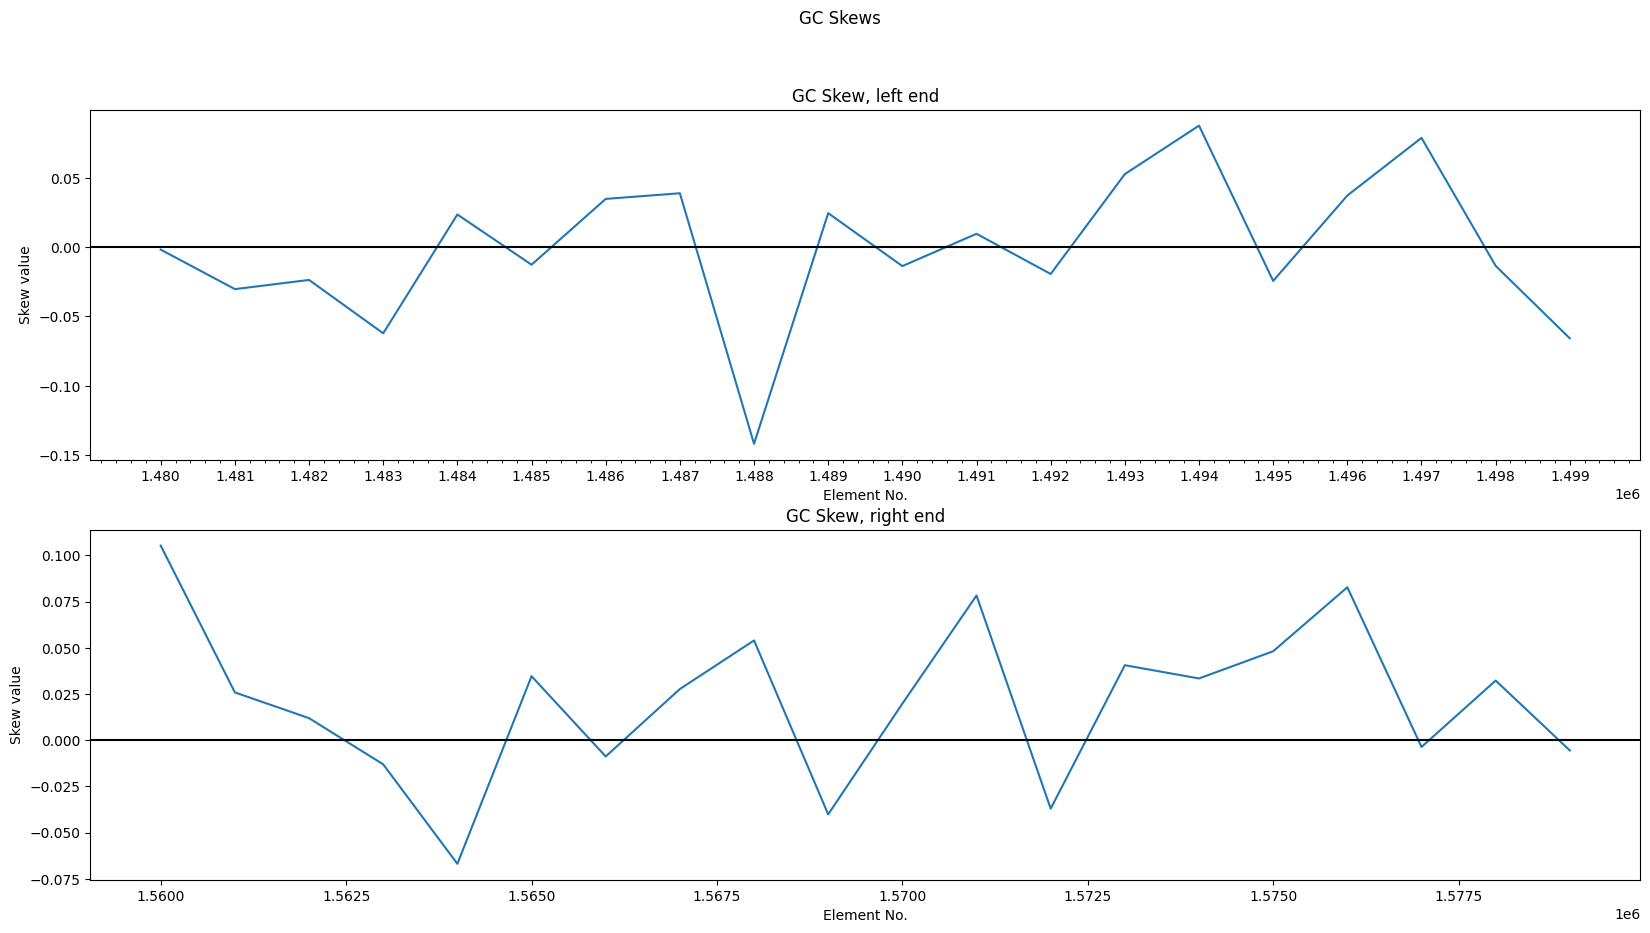

In [507]:
window_size1 = 1000

fig_3, (ax_l, ax_r) = plt.subplots(2, 1, figsize=(20, 10))
fig_3.suptitle("GC Skews")

border_left_l = 1480*1000
border_right_l = 1500*1000

seq_l = seq_orig[border_left_l:border_right_l]
skew_l = SU.GC_skew(seq_l, window_size1)

ax_l.set_title("GC Skew, left end")
ax_l.plot(range(border_left_l, border_right_l, window_size1), skew_l)
ax_l.set_xlabel("Element No.")
ax_l.set_ylabel("Skew value")
ax_l.xaxis.set_minor_locator(MultipleLocator(200))
ax_l.xaxis.set_major_locator(MultipleLocator(1000))
ax_l.axhline(0, color='black')

border_left_r = 1560*1000
border_right_r = 1580*1000

seq_r = seq_orig[border_left_r:border_right_r]
skew_r = SU.GC_skew(seq_r, window_size1)

ax_r.set_title("GC Skew, right end")
ax_r.plot(range(border_left_r, border_right_r, window_size1), skew_r)
ax_r.set_xlabel("Element No.")
ax_r.set_ylabel("Skew value")
ax_l.xaxis.set_minor_locator(MultipleLocator(200))
ax_l.xaxis.set_major_locator(MultipleLocator(1000))
ax_r.axhline(0, color='black')

plt.show()

Рассмотрим еще ближе.

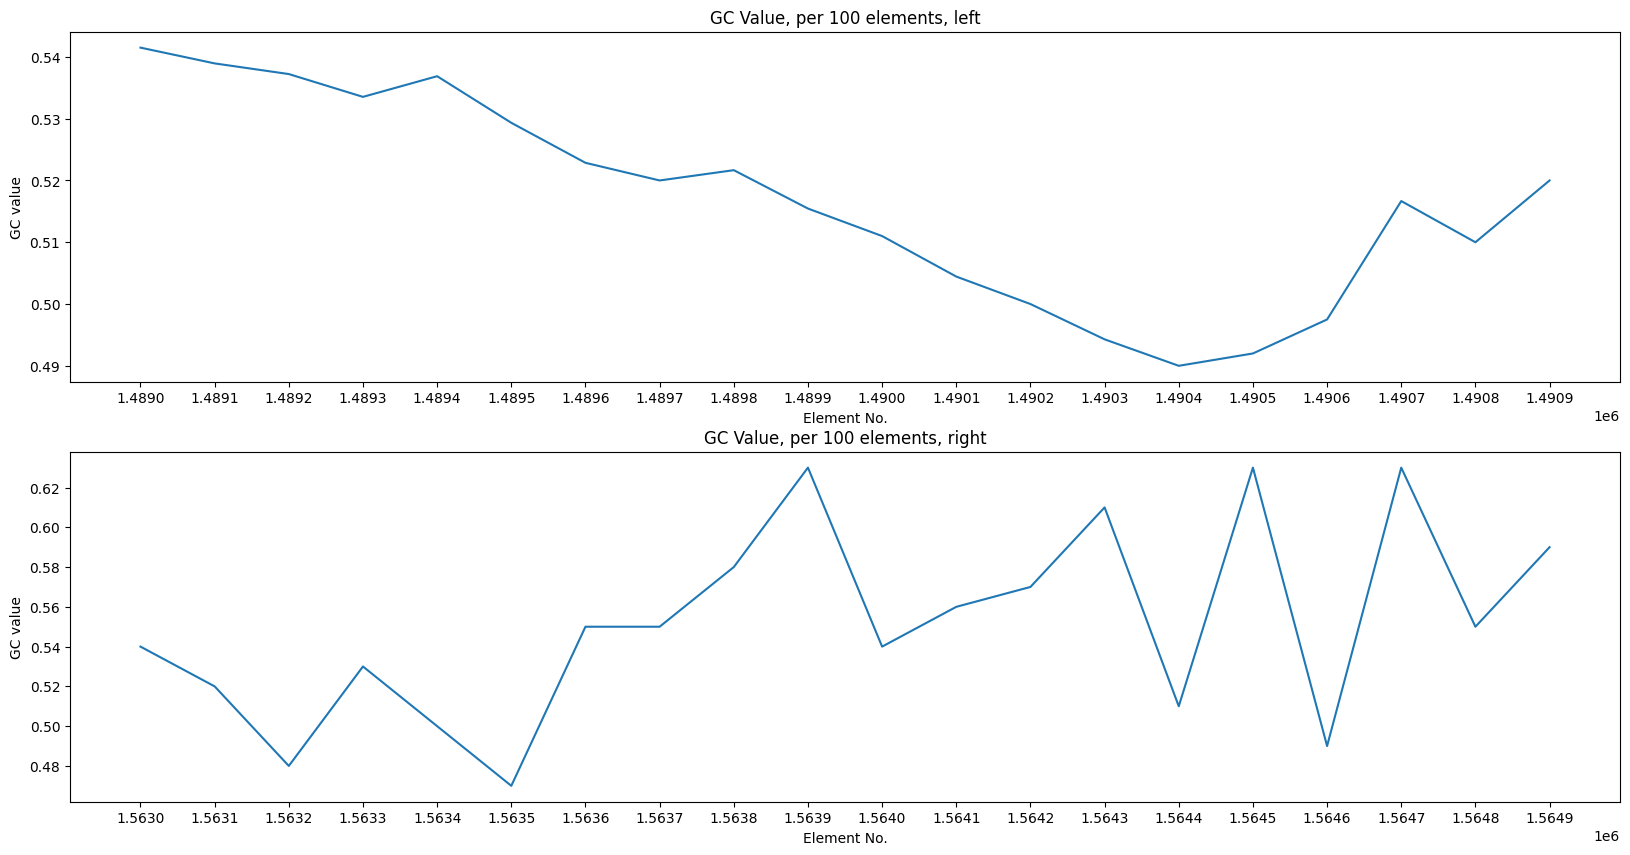

In [508]:
border_left_l = 1489*1000
border_right_l = 1491*1000
seq_l = seq_orig[border_left_l:border_right_l]
gc_list_l = []

step = 100

for i in range(0, len(seq_l), step):
    lb = step
    if i+step <= len(seq_l):
        lb = len(seq_l)-i

    gc_list_l.append(SU.gc_fraction(seq_l[i:i+lb]))

fig_17_23, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))
ax1.set_title(f"GC Value, per {step} elements, left")
ax1.plot(range(border_left_l, border_right_l, step), gc_list_l)
ax1.set_xlabel("Element No.")
ax1.set_ylabel("GC value")
ax1.xaxis.set_minor_locator(MultipleLocator(100))
ax1.xaxis.set_major_locator(MultipleLocator(100))

gc_list_r = []
border_left_r = 1563*1000
border_right_r = 1565*1000
seq_r = seq_orig[border_left_r:border_right_r]

for i in range(0, len(seq_r), step):
    lb = step
    if i+step >= len(seq_r):
        lb = len(seq_r)-i

    gc_list_r.append(SU.gc_fraction(seq_r[i:i+lb]))

ax2.set_title(f'GC Value, per {step} elements, right')
ax2.plot(range(border_left_r, border_right_r, step), gc_list_r)
ax2.set_xlabel("Element No.")
ax2.set_ylabel("GC value")
ax2.xaxis.set_minor_locator(MultipleLocator(100))
ax2.xaxis.set_major_locator(MultipleLocator(100))

plt.show()

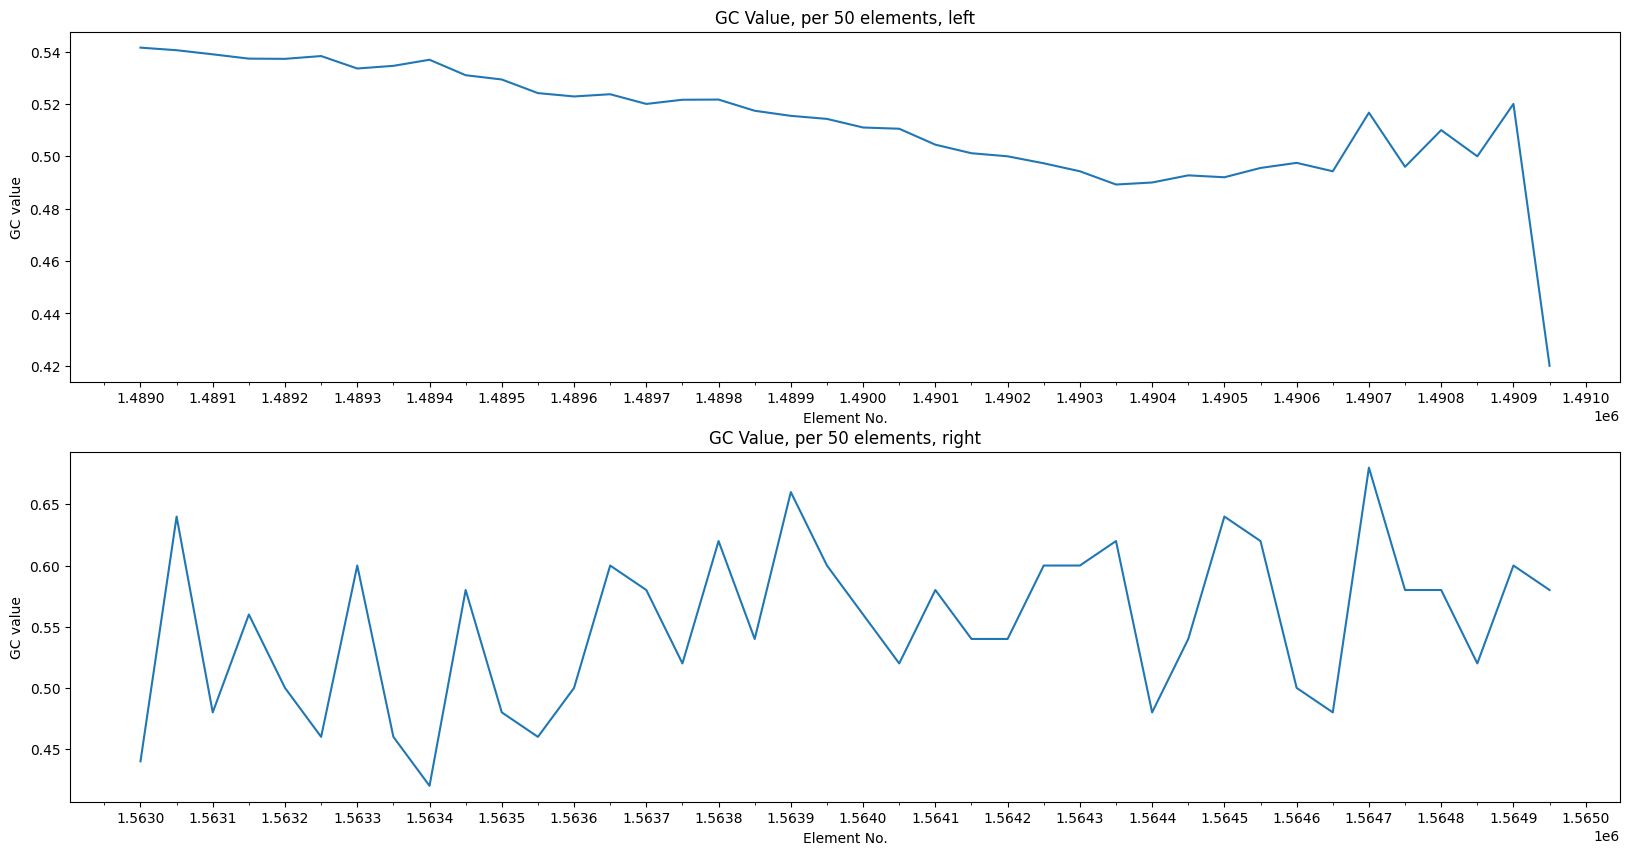

In [509]:
border_left_l = 1489*1000
border_right_l = 1491*1000
seq_l = seq_orig[border_left_l:border_right_l]
gc_list_l = []

step = 50

for i in range(0, len(seq_l), step):
    lb = step
    if i+step <= len(seq_l):
        lb = len(seq_l)-i

    gc_list_l.append(SU.gc_fraction(seq_l[i:i+lb]))

fig_17_23, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))
ax1.set_title(f"GC Value, per {step} elements, left")
ax1.plot(range(border_left_l, border_right_l, step), gc_list_l)
ax1.set_xlabel("Element No.")
ax1.set_ylabel("GC value")
ax1.xaxis.set_minor_locator(MultipleLocator(50))
ax1.xaxis.set_major_locator(MultipleLocator(100))

gc_list_r = []
border_left_r = 1563*1000
border_right_r = 1565*1000
seq_r = seq_orig[border_left_r:border_right_r]

for i in range(0, len(seq_r), step):
    lb = step
    if i+step >= len(seq_r):
        lb = len(seq_r)-i

    gc_list_r.append(SU.gc_fraction(seq_r[i:i+lb]))

ax2.set_title(f'GC Value, per {step} elements, right')
ax2.plot(range(border_left_r, border_right_r, step), gc_list_r)
ax2.set_xlabel("Element No.")
ax2.set_ylabel("GC value")
ax2.xaxis.set_minor_locator(MultipleLocator(50))
ax2.xaxis.set_major_locator(MultipleLocator(100))

plt.show()

### Ответ

**Левая граница** = 1490350

**Правая граница** = 1563900


## Case 3

Original record length: 19696


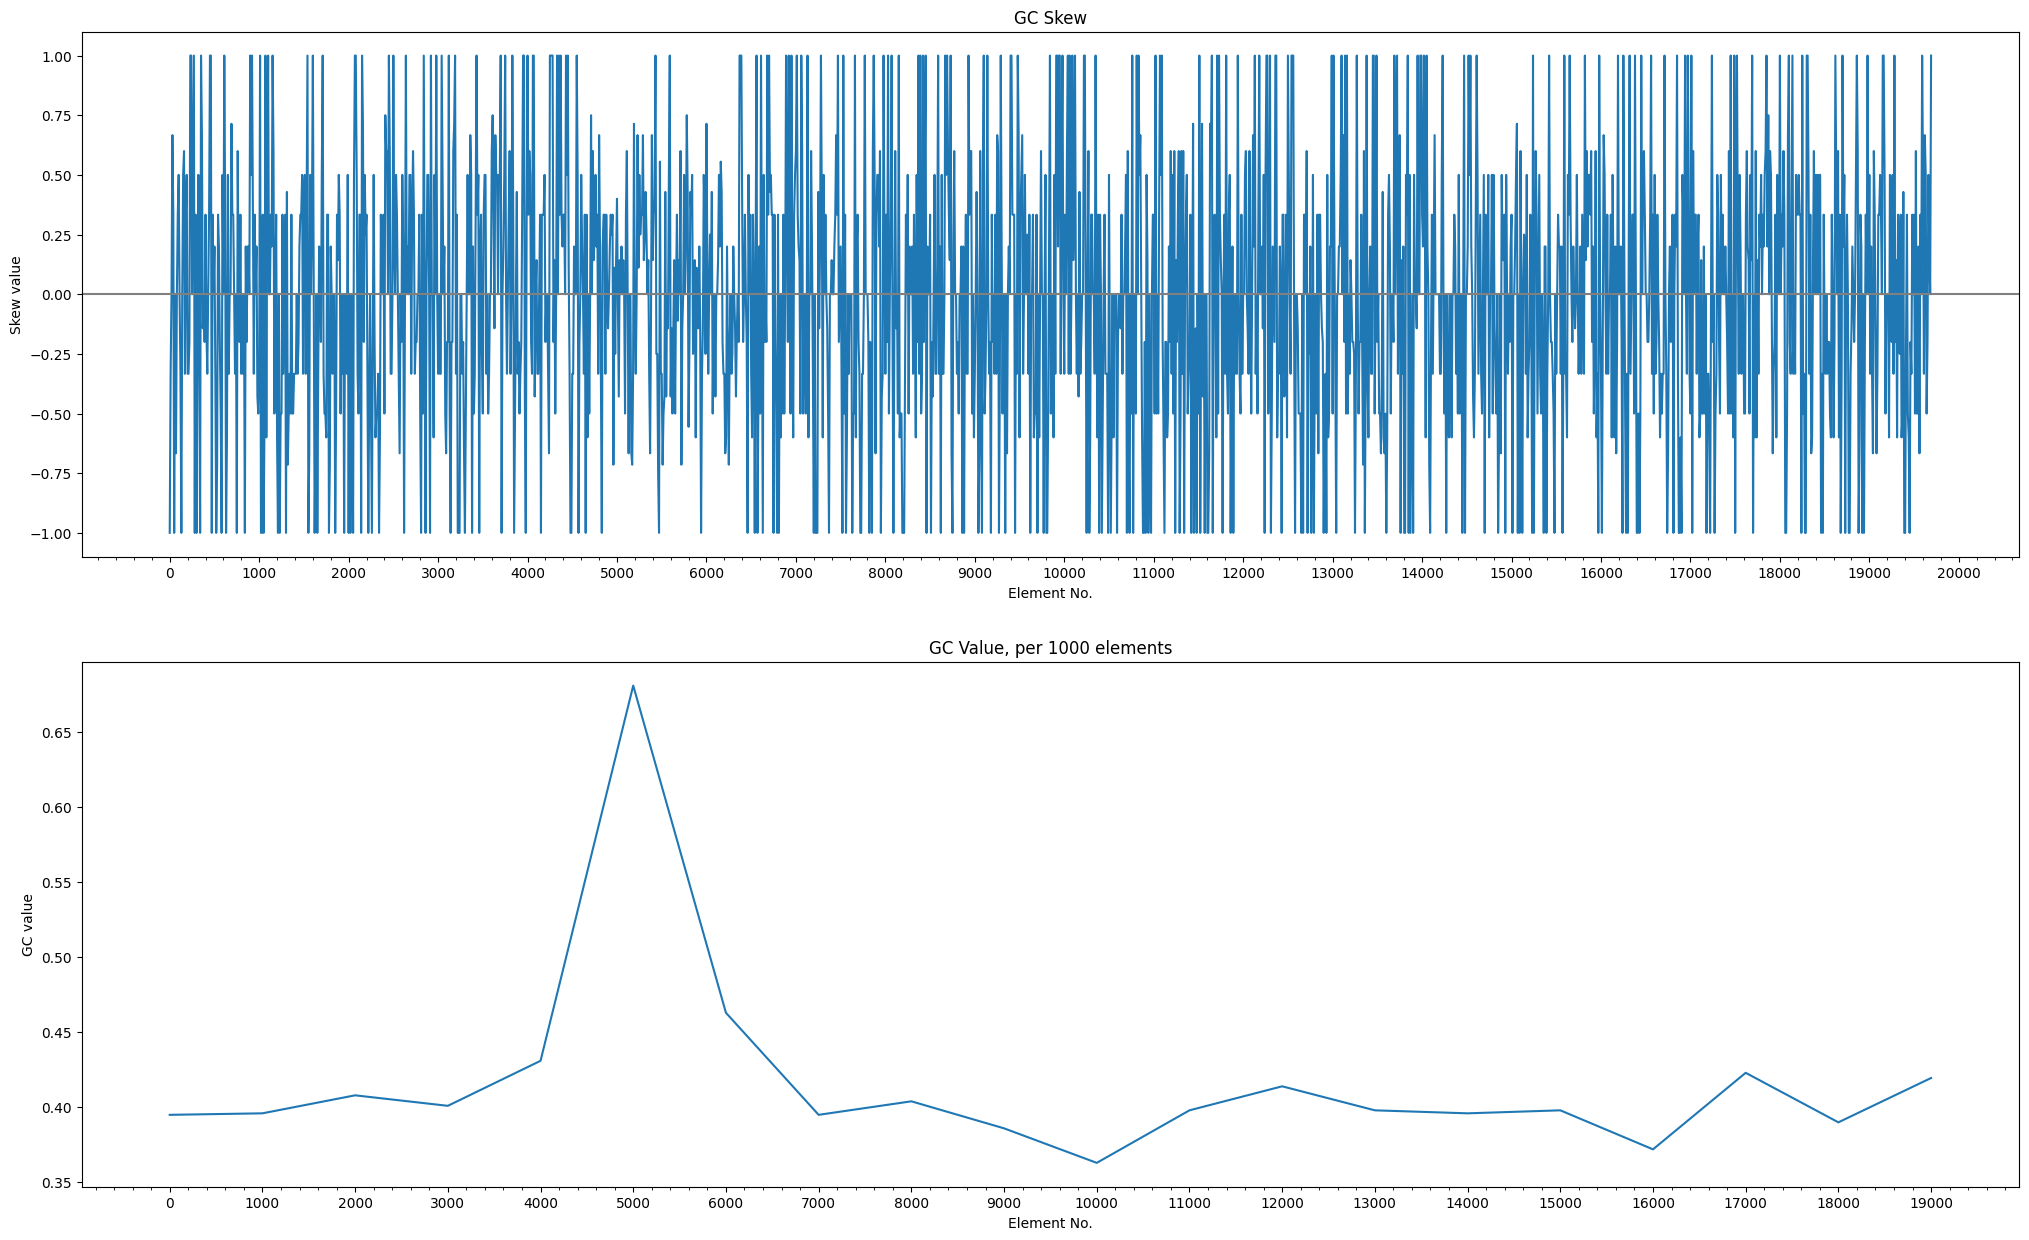

In [510]:
import Bio.SeqUtils as SU
from Bio.Seq import Seq
from Bio.SeqUtils import GC
from Bio import SeqIO

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
seq_orig = ""

with open("03.fasta") as handle:
    for record in SeqIO.parse(handle, "fasta"):
        seq_orig = record


print(f'Original record length: {seq_orig.__len__()}')

current_sub = ""
current_max_insertion = ""

window_size = 10

skew = SU.GC_skew(seq_orig, window_size)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 15))
ax1.set_title("GC Skew")
ax1.plot(range(0, len(seq_orig), window_size), skew)
ax1.set_xlabel("Element No.")
ax1.set_ylabel("Skew value")
ax1.xaxis.set_minor_locator(MultipleLocator(200))
ax1.xaxis.set_major_locator(MultipleLocator(1000))
ax1.axhline(0, color='grey')

step = 1000
gc_list = []
for i in range(0, len(seq_orig), step):
    lb = step
    if i+step >= len(seq_orig):
        lb = len(seq_orig)-i

    gc_list.append(SU.gc_fraction(seq_orig[i:i+lb]))

ax2.set_title(f'GC Value, per {step} elements')
ax2.plot(range(0, len(seq_orig), step), gc_list)
ax2.set_xlabel("Element No.")
ax2.set_ylabel("GC value")
ax2.xaxis.set_minor_locator(MultipleLocator(200))
ax2.xaxis.set_major_locator(MultipleLocator(1000))

plt.show()


Между 3000 и 7000 аномально большое значение GC. GC skew пониженный между 4800 и 6600.

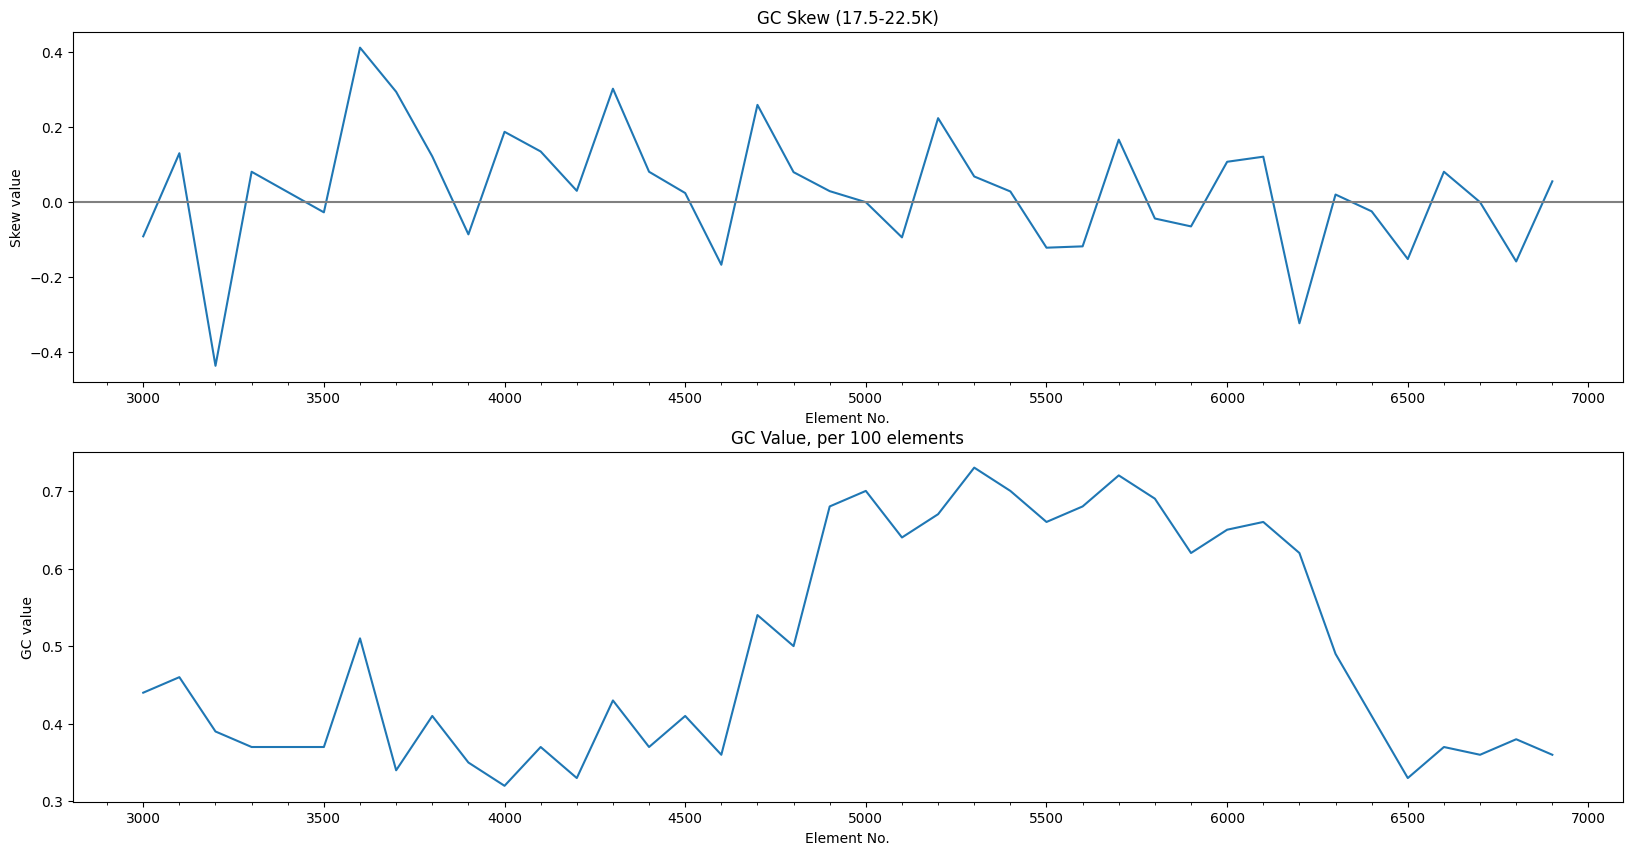

In [511]:
window_size = 100

border_left = 3000
border_right = 7000

seq_17_23 = seq_orig[border_left:border_right]

skew_17_23 = SU.GC_skew(seq_17_23, window_size)

fig_17_23, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))
ax1.set_title("GC Skew (17.5-22.5K)")
ax1.plot(range(border_left, border_right, window_size), skew_17_23)
ax1.set_xlabel("Element No.")
ax1.set_ylabel("Skew value")
ax1.xaxis.set_minor_locator(MultipleLocator(100))
ax1.xaxis.set_major_locator(MultipleLocator(500))
ax1.axhline(0, color='grey')

step = 100
gc_list = []
for i in range(0, len(seq_17_23), step):
    lb = step
    if i+step >= len(seq_17_23):
        lb = len(seq_17_23)-i

    gc_list.append(SU.gc_fraction(seq_17_23[i:i+lb]))

ax2.set_title(f'GC Value, per {step} elements')
ax2.plot(range(border_left, border_right, step), gc_list)
ax2.set_xlabel("Element No.")
ax2.set_ylabel("GC value")
ax2.xaxis.set_minor_locator(MultipleLocator(100))
ax2.xaxis.set_major_locator(MultipleLocator(500))


plt.show()


Искомый отрезок находится где-то между 4900 и 6400.

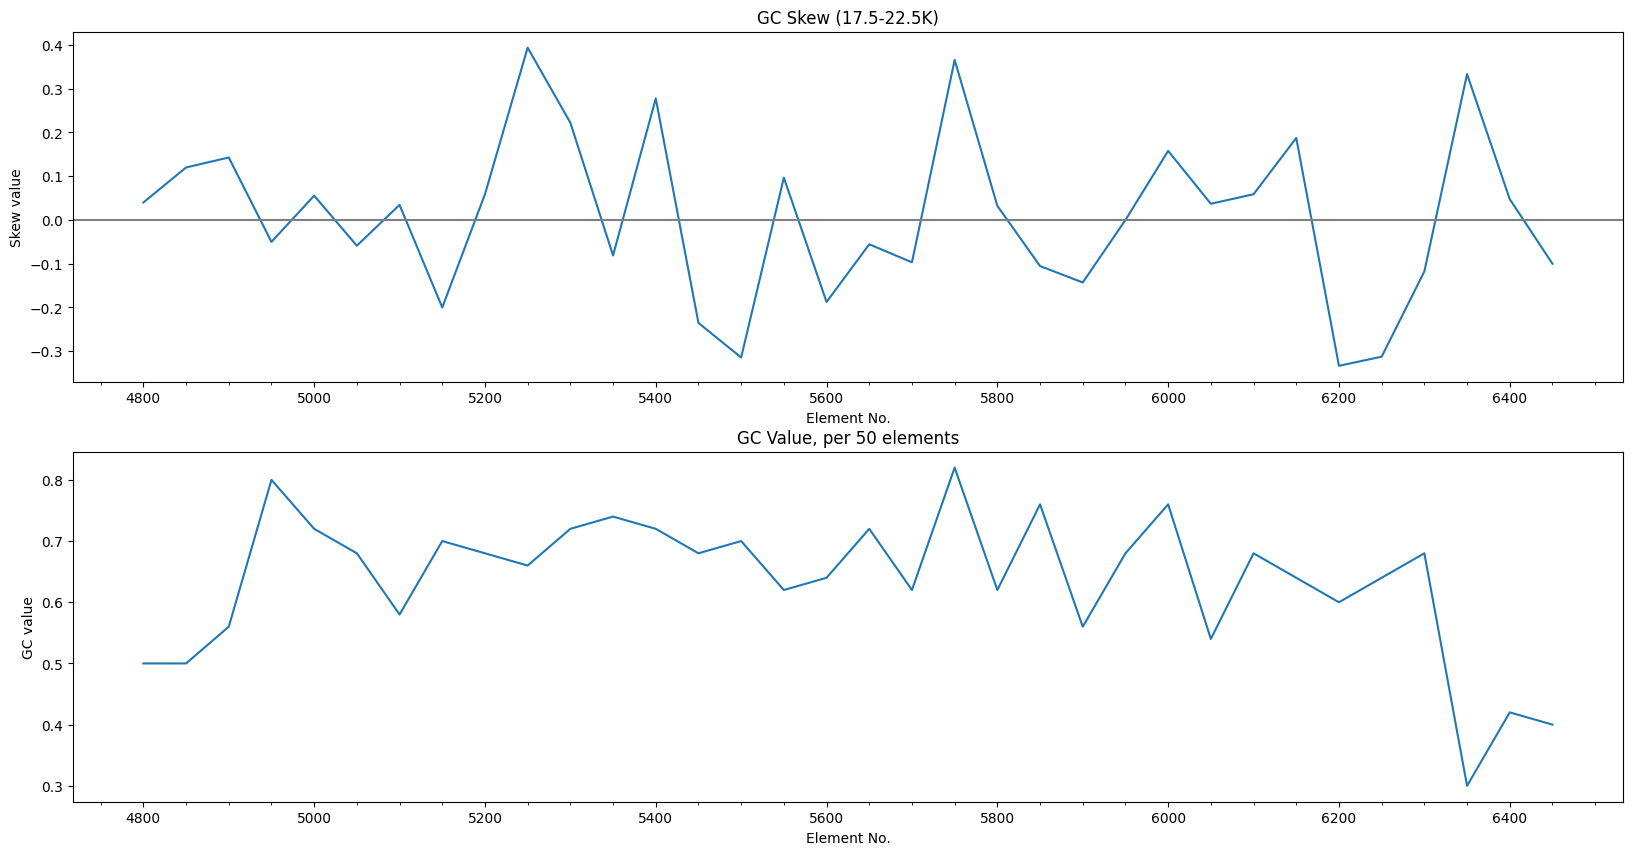

In [512]:
window_size = 50

border_left = 4800
border_right = 6500

seq_17_23 = seq_orig[border_left:border_right]

skew_17_23 = SU.GC_skew(seq_17_23, window_size)

fig_17_23, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))
ax1.set_title("GC Skew (17.5-22.5K)")
ax1.plot(range(border_left, border_right, window_size), skew_17_23)
ax1.set_xlabel("Element No.")
ax1.set_ylabel("Skew value")
ax1.xaxis.set_minor_locator(MultipleLocator(50))
ax1.xaxis.set_major_locator(MultipleLocator(200))
ax1.axhline(0, color='grey')

step = 50
gc_list = []
for i in range(0, len(seq_17_23), step):
    lb = step
    if i+step >= len(seq_17_23):
        lb = len(seq_17_23)-i

    gc_list.append(SU.gc_fraction(seq_17_23[i:i+lb]))

ax2.set_title(f'GC Value, per {step} elements')
ax2.plot(range(border_left, border_right, step), gc_list)
ax2.set_xlabel("Element No.")
ax2.set_ylabel("GC value")
ax2.xaxis.set_minor_locator(MultipleLocator(50))
ax2.xaxis.set_major_locator(MultipleLocator(200))


plt.show()


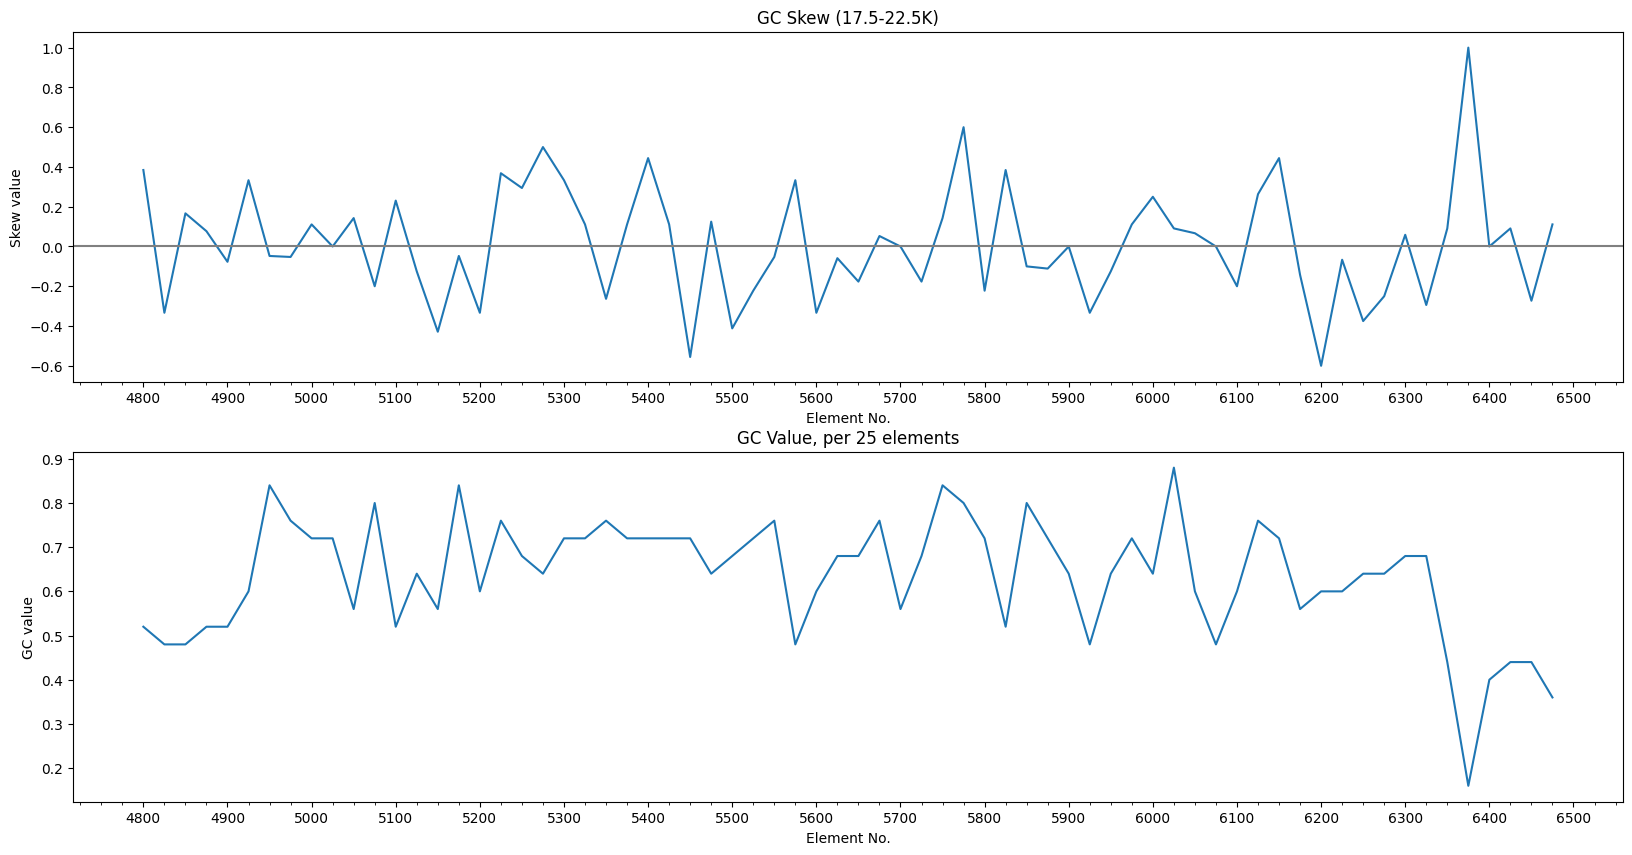

In [513]:
window_size = 25

border_left = 4800
border_right = 6500

seq_17_23 = seq_orig[border_left:border_right]

skew_17_23 = SU.GC_skew(seq_17_23, window_size)

fig_17_23, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))
ax1.set_title("GC Skew (17.5-22.5K)")
ax1.plot(range(border_left, border_right, window_size), skew_17_23)
ax1.set_xlabel("Element No.")
ax1.set_ylabel("Skew value")
ax1.xaxis.set_minor_locator(MultipleLocator(25))
ax1.xaxis.set_major_locator(MultipleLocator(100))
ax1.axhline(0, color='grey')

step = 25
gc_list = []
for i in range(0, len(seq_17_23), step):
    lb = step
    if i+step >= len(seq_17_23):
        lb = len(seq_17_23)-i

    gc_list.append(SU.gc_fraction(seq_17_23[i:i+lb]))

ax2.set_title(f'GC Value, per {step} elements')
ax2.plot(range(border_left, border_right, step), gc_list)
ax2.set_xlabel("Element No.")
ax2.set_ylabel("GC value")
ax2.xaxis.set_minor_locator(MultipleLocator(25))
ax2.xaxis.set_major_locator(MultipleLocator(100))


plt.show()


Вряд ли из рисунка выше можно вывести более точное решение.

#### Ответ

**Правая граница** = 4925

**Левая граница** = 6350

## Case 4

Original record length: 1638326


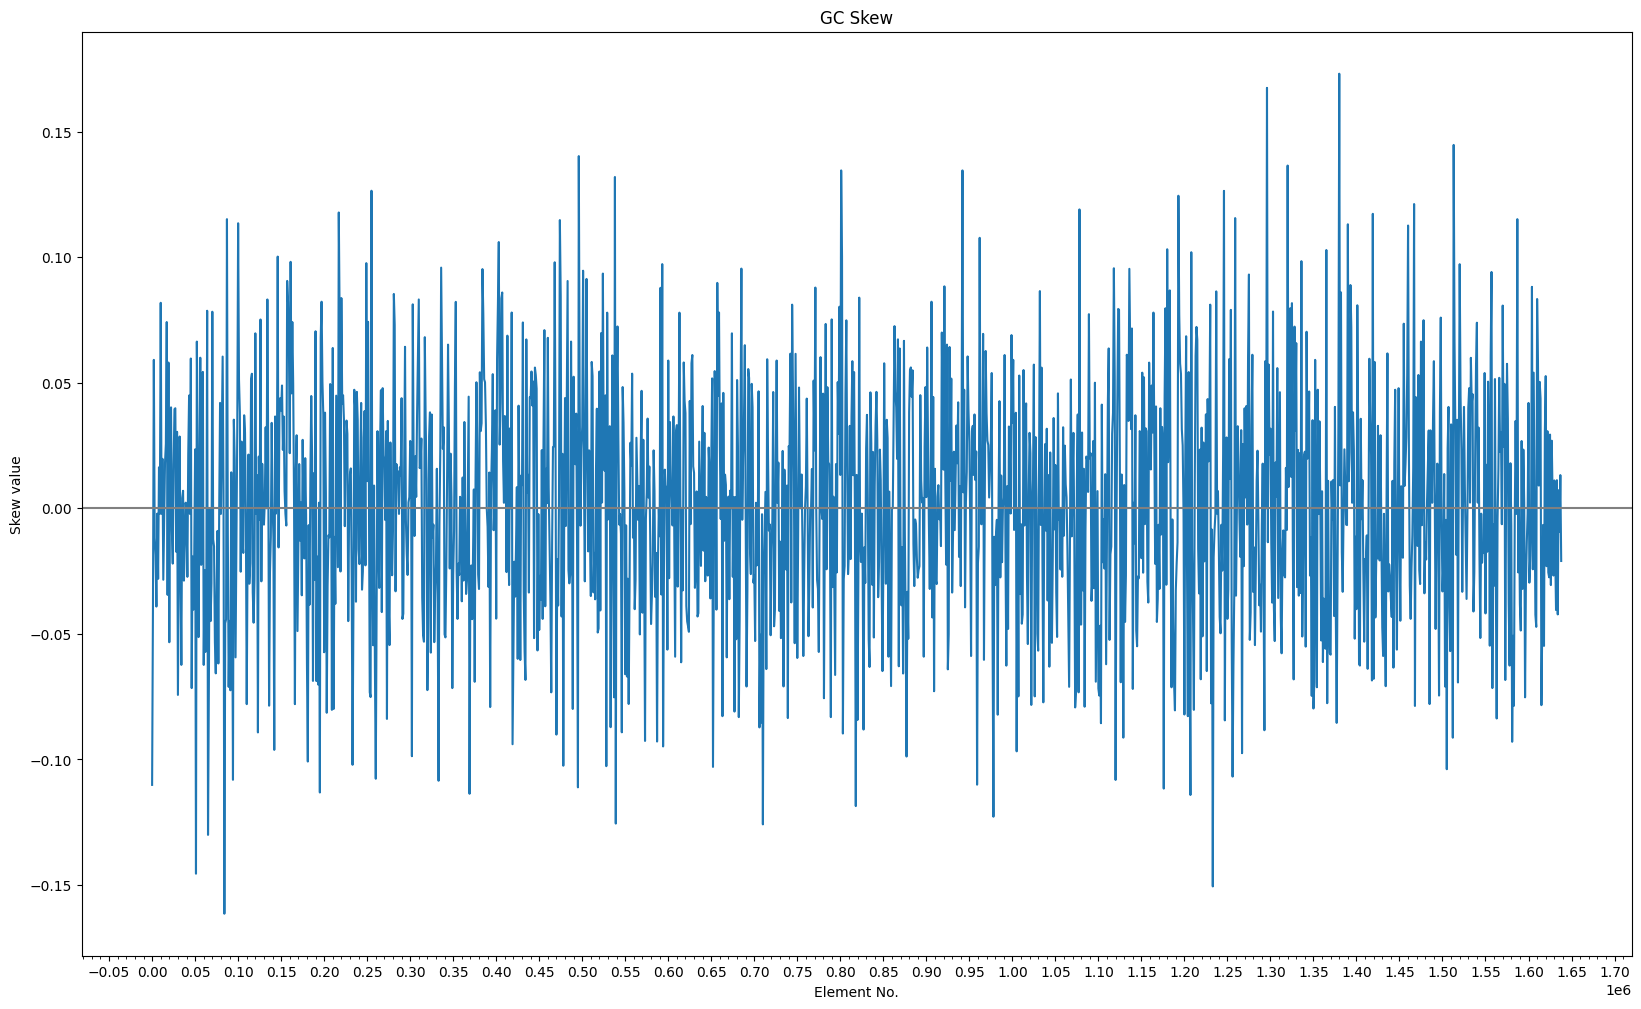

In [514]:
import Bio.SeqUtils as SU
from Bio.Seq import Seq
from Bio.SeqUtils import GC
from Bio import SeqIO

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
seq_orig = ""

with open("04.fasta") as handle:
    for record in SeqIO.parse(handle, "fasta"):
        seq_orig = record


print(f'Original record length: {seq_orig.__len__()}')

current_sub = ""
current_max_insertion = ""

window_size =1000

skew = SU.GC_skew(seq_orig, window_size)

fig, ax = plt.subplots(figsize=(20, 12))
ax.set_title("GC Skew")
ax.plot(range(0, len(seq_orig), window_size), skew)
ax.set_xlabel("Element No.")
ax.set_ylabel("Skew value")
ax.xaxis.set_minor_locator(MultipleLocator(10000))
ax.xaxis.set_major_locator(MultipleLocator(50000))
ax.axhline(0, color='grey')
plt.show()


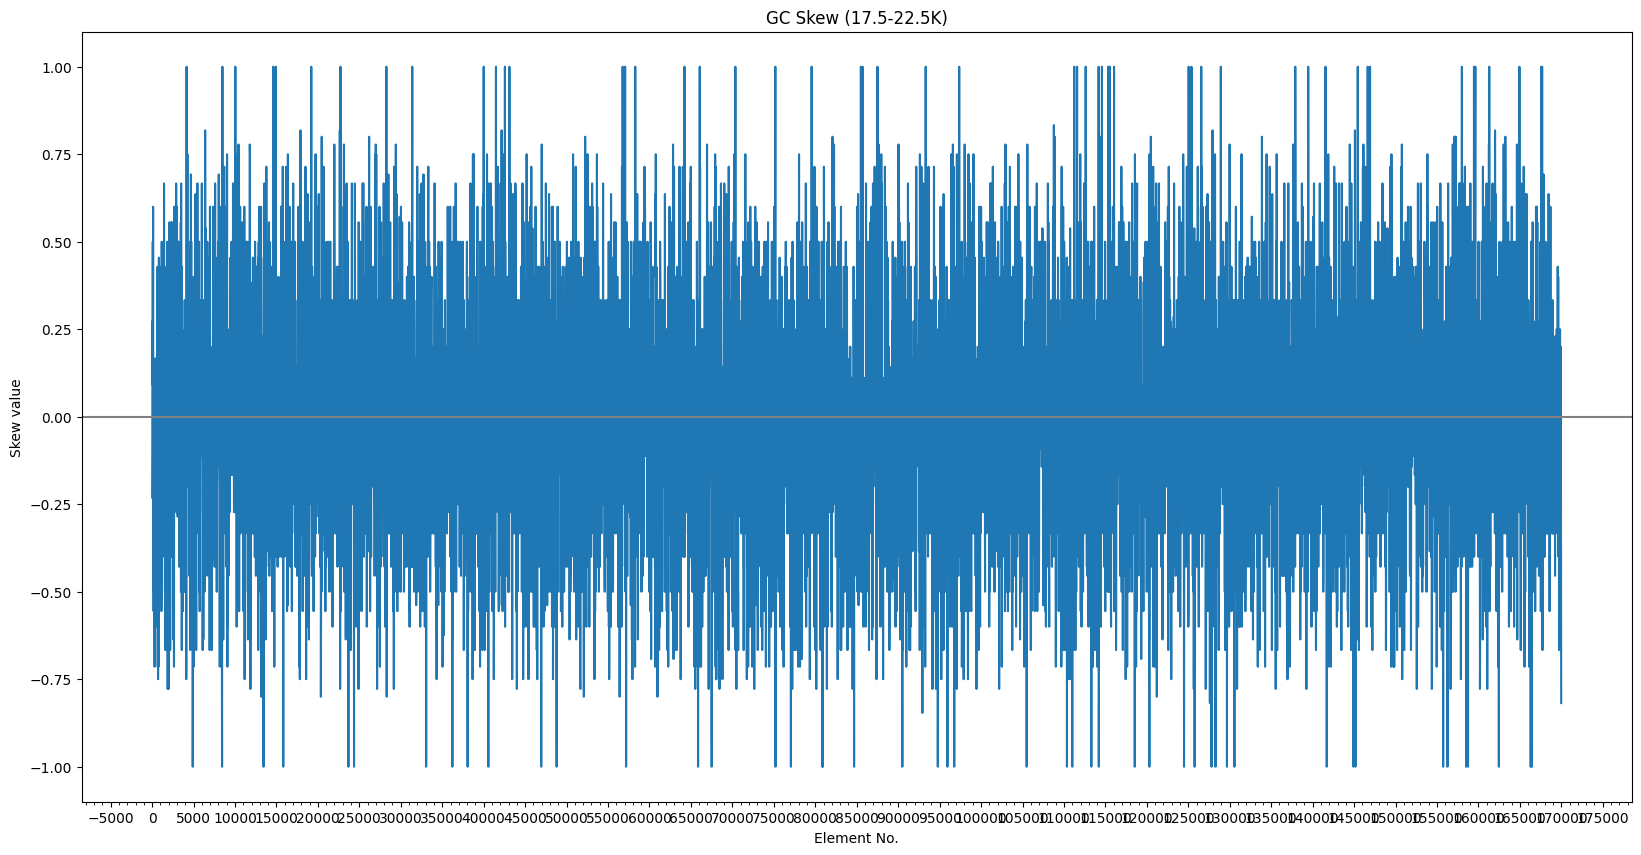

In [515]:
window_size = 20

border_left = 3
border_right = 170000

seq_17_23 = seq_orig[border_left:border_right]

skew_17_23 = SU.GC_skew(seq_17_23, window_size)

fig_17_23, ax17_23 = plt.subplots(figsize=(20, 10))
ax17_23.set_title("GC Skew (17.5-22.5K)")
ax17_23.plot(range(border_left, border_right, window_size), skew_17_23)
ax17_23.set_xlabel("Element No.")
ax17_23.set_ylabel("Skew value")
ax17_23.xaxis.set_minor_locator(MultipleLocator(1000))
ax17_23.xaxis.set_major_locator(MultipleLocator(5000))
ax17_23.axhline(0, color='grey')

plt.show()